# Proyecto de Clasificación: Detección de Phishing

Este cuaderno reproduce el pipeline completo desarrollado para el proyecto de clasificación.
 El objetivo es entrenar y comparar dos variantes del modelo Gaussian Naive Bayes:

- Variante 1: Entrenamiento con **todas las variables** disponibles.
- Variante 2: Entrenamiento tras **optimizar la selección de variables** (top 5 features) y optimizando el hiperparametro. Manteniendo la misma semilla para consistencia.

La comparación final permitirá cuantificar el impacto real de optimizar las variables sobre el desempeño del modelo.


## Ruta de trabajo y estructura del cuaderno

1. Configuración inicial y carga de librerías.
2. Exploración y validación del dataset original.
3. Preparación de datos para el modelo (separación, escalado y particiones).
4. Entrenamiento del modelo base con todas las variables.
5. Selección aleatoria guiada de características (semilla 42).
6. Variante 2 con tuning de `var_smoothing` (semilla 42).
7. Comparación cuantitativa entre variantes.
8. Conclusiones.


In [1]:
import os
import sys
from pathlib import Path
from collections import Counter
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix
)

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)

# Configuración de estilo para las figuras
try:
    plt.style.use("seaborn-v0_8")
except OSError:
    plt.style.use("seaborn")

sns.set_palette("husl")

# Configuración de rutas y semilla global
PROJECT_ROOT = Path("/home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI").resolve()
DATA_DIR = PROJECT_ROOT / "Data" / "phishing+websites"
RESULTS_DIR = PROJECT_ROOT / "Data" / "resultados_notebook"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

GLOBAL_RANDOM_STATE = 42
np.random.seed(GLOBAL_RANDOM_STATE)
random.seed(GLOBAL_RANDOM_STATE)

from utils import cargar_dataset_phishing



## 1. Carga y exploración inicial del dataset

Comenzamos recuperando el conjunto completo de sitios web de phishing desde el archivo ARFF original. Realizaremos una exploración descriptiva rápida para asegurarnos de que la estructura coincide con la utilizada en los scripts del proyecto.


In [2]:
df_raw = cargar_dataset_phishing()

print("=" * 70)
print("DATASET ORIGINAL: RESUMEN ESTRUCTURAL")
print("=" * 70)
print(f"Filas: {df_raw.shape[0]:,} | Columnas: {df_raw.shape[1]:,}")
print(f"Columnas (primeras 5): {df_raw.columns[:5].tolist()} ...")
print(f"Tipos de datos únicos: {df_raw.dtypes.value_counts().to_dict()}")
print(f"Valores objetivo disponibles: {sorted(df_raw['Result'].unique())}")

print("\nPrimeras filas (muestra):")
df_raw.head().style.format(precision=3)


DATASET ORIGINAL: RESUMEN ESTRUCTURAL
Filas: 11,055 | Columnas: 31
Columnas (primeras 5): ['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting'] ...
Tipos de datos únicos: {dtype('O'): 30, dtype('int64'): 1}
Valores objetivo disponibles: [np.int64(-1), np.int64(1)]

Primeras filas (muestra):


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


### Validación de integridad y distribución de clases

Confirmamos la codificación binaria, buscamos valores faltantes y analizamos la distribución de clases, replicando las verificaciones del módulo `preprocessing.py`.


✓ Codificación binaria verificada: -1 (legítimo), 1 (phishing)
✓ No se detectaron valores faltantes en el dataset

Distribución de clases (conteos):
Result
-1    4898
 1    6157
Name: count, dtype: int64

Distribución de clases (porcentaje):
Result
-1    44.31
 1    55.69
Name: count, dtype: float64


/tmp/ipykernel_79383/2809010048.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Legítimo (-1)", "Phishing (1)"])


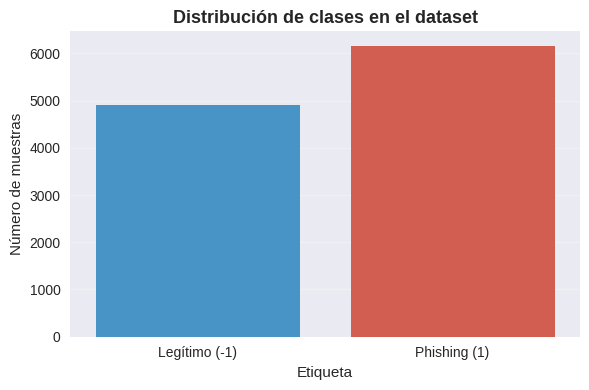

✓ Gráfica de distribución guardada en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/distribucion_clases_notebook.png


In [3]:
target_column = "Result"

# Codificación binaria
unique_target_values = set(df_raw[target_column].unique())
esperado = {-1, 1}
assert unique_target_values == esperado, (
    f"La variable objetivo no cumple con la codificación esperada {-1, 1}. Encontrado: {unique_target_values}"
)
print("✓ Codificación binaria verificada: -1 (legítimo), 1 (phishing)")

# Valores faltantes
missing_values = df_raw.isnull().sum()
total_missing = missing_values.sum()
if total_missing == 0:
    print("✓ No se detectaron valores faltantes en el dataset")
else:
    print(f"⚠ Valores faltantes totales: {total_missing}")
    display(missing_values[missing_values > 0])

# Distribución de clases
class_distribution = df_raw[target_column].value_counts().sort_index()
class_percentages = (class_distribution / len(df_raw) * 100).round(2)

print("\nDistribución de clases (conteos):")
print(class_distribution)
print("\nDistribución de clases (porcentaje):")
print(class_percentages)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["#3498db", "#e74c3c"], ax=ax)
ax.set_title("Distribución de clases en el dataset", fontsize=13, fontweight="bold")
ax.set_xlabel("Etiqueta")
ax.set_ylabel("Número de muestras")
ax.set_xticklabels(["Legítimo (-1)", "Phishing (1)"])
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

# Guardar artefacto para replicar los scripts originales
fig_path = RESULTS_DIR / "distribucion_clases_notebook.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"✓ Gráfica de distribución guardada en: {fig_path}")


## 2. Preparación de variables y particionado estratificado

Separamos las características de la variable objetivo y aplicamos una partición estratificada 80/20 para entrenamiento y prueba, asegurando reproducibilidad con `random_state=42`.


In [4]:
df = df_raw.copy()
X_full = df.drop(columns=[target_column])
y_full = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=GLOBAL_RANDOM_STATE,
    stratify=y_full
)

print("=" * 70)
print("DIVISIÓN ESTRATIFICADA 80/20")
print("=" * 70)
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} | y_test: {y_test.shape}")

train_distribution = y_train.value_counts(normalize=True).sort_index()
test_distribution = y_test.value_counts(normalize=True).sort_index()

print("\nProporción de clases en entrenamiento:")
print((train_distribution * 100).round(2))
print("\nProporción de clases en prueba:")
print((test_distribution * 100).round(2))


DIVISIÓN ESTRATIFICADA 80/20
X_train: (8844, 30) | X_test: (2211, 30)
y_train: (8844,) | y_test: (2211,)

Proporción de clases en entrenamiento:
Result
-1    44.3
 1    55.7
Name: proportion, dtype: float64

Proporción de clases en prueba:
Result
-1    44.32
 1    55.68
Name: proportion, dtype: float64


### Estrategia de validación y control de aleatoriedad

- **Partición inicial:** Utilizamos un `train_test_split` estratificado con `random_state=42`, lo que garantiza la misma distribución de clases en ambos subconjuntos y permite reproducir los resultados.
- **Validación cruzada para tuning:** Durante la optimización de `var_smoothing` aplicamos `StratifiedKFold` (5 folds, `shuffle=True`, `random_state=42`). Este esquema mantiene el balance de clases en cada fold y reutiliza la misma semilla para asegurar consistencia.
- **Justificación:** El dataset cuenta con más de 10k instancias; la combinación de un hold-out estratificado (para evaluar el modelo final) y validación cruzada (para ajustar hiperparámetros con F1-score) ofrece un equilibrio entre costo computacional y calidad de la estimación.
- **Control de procesos estocásticos:** Todas las funciones que implican aleatoriedad (partición, búsqueda aleatoria de variables y validación cruzada) reciben explícitamente `random_state=42`, cumpliendo el requisito de reproducibilidad del proyecto.



## 3. Funciones auxiliares para entrenamiento y evaluación

Estandarizamos las operaciones recurrentes del pipeline: escalado, entrenamiento del modelo GaussianNB y cálculo de métricas relevantes. Además, implementamos una versión controlada del `Random Search` para selección de características, replicando la lógica del módulo `feature_selection.py` con salidas resumidas y reproducibles.


In [5]:
def escalar_caracteristicas(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    return X_train_scaled, X_test_scaled, scaler


def entrenar_gnb(X_train, y_train):
    modelo = GaussianNB()
    modelo.fit(X_train, y_train)
    return modelo


def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    metricas = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1-score": f1_score(y_test, y_pred, pos_label=1),
    }

    y_test_binario = (y_test == 1).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test_binario, y_proba)
    roc_auc = auc(fpr, tpr)
    metricas["AUC-ROC"] = roc_auc

    matriz = confusion_matrix(y_test, y_pred, labels=[-1, 1])

    return {
        "metricas": metricas,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "matriz_confusion": matriz,
        "roc": {
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thresholds,
            "auc": roc_auc,
        },
    }


def random_search_feature_selection(X_train, y_train, n_iter=500, k=5, random_state=42):
    rng = random.Random(random_state)
    features = X_train.columns.tolist()
    mejor_f1 = -np.inf
    mejor_subset = None
    registros = []
    frecuencias = Counter()

    X_sel_train, X_sel_val, y_sel_train, y_sel_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=random_state,
        stratify=y_train
    )

    for iteracion in range(1, n_iter + 1):
        subset = rng.sample(features, k)
        modelo = GaussianNB()
        modelo.fit(X_sel_train[subset], y_sel_train)
        y_pred_val = modelo.predict(X_sel_val[subset])
        f1 = f1_score(y_sel_val, y_pred_val, pos_label=1)

        registros.append({
            "iteracion": iteracion,
            "subset": subset,
            "f1_score": f1
        })

        if f1 > mejor_f1 + 1e-6:
            mejor_f1 = f1
            mejor_subset = subset
            frecuencias.update(subset)

    resultados_df = pd.DataFrame(registros).sort_values(by="f1_score", ascending=False)
    top_features = [feature for feature, _ in frecuencias.most_common(k)]

    resumen = {
        "mejor_f1": mejor_f1,
        "mejor_subset": mejor_subset,
        "frecuencias": frecuencias,
        "log": resultados_df.reset_index(drop=True),
        "top_features": top_features,
    }

    return resumen


def optimizar_var_smoothing(
    X_train,
    y_train,
    random_state=42,
    n_splits=5,
    rango_log=(-9, -3, 10)
):
    valores = np.logspace(rango_log[0], rango_log[1], rango_log[2])
    param_grid = {"var_smoothing": valores}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=GaussianNB(),
        param_grid=param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)

    return {
        "best_model": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
        "grid_search": grid_search
    }


## 4. Variante 1 — Modelo base con todas las variables

Ejecutamos Gaussian Naive Bayes sobre el dataset completo (sin selección de características). El escalado se realiza únicamente con datos de entrenamiento para prevenir *data leakage*.


**Interpretación de métricas (modelo base):**
- `Precision` refleja qué porcentaje de las alertas de phishing emitidas por el modelo son correctas (minimiza falsos positivos).
- `Recall` indica qué proporción de sitios de phishing fue detectada efectivamente (controla los falsos negativos, el riesgo más crítico en este dominio).
- `F1-score` equilibra ambos factores y será la métrica objetivo para comparar modelos y optimizar hiperparámetros, según lo requiere la consigna del proyecto.



In [6]:
X_train_all_scaled, X_test_all_scaled, scaler_all = escalar_caracteristicas(X_train, X_test)
modelo_base = entrenar_gnb(X_train_all_scaled, y_train)
resultados_base = evaluar_modelo(modelo_base, X_test_all_scaled, y_test)

pd.DataFrame([resultados_base["metricas"]]).set_index(
    pd.Index(["Modelo base (todas las variables)"])
)


,Accuracy,Precision,Recall,F1-score,AUC-ROC
Modelo base (todas las variables),0.5975,1.0,0.277,0.4338,0.9702


Matriz de confusión — Modelo base:


,Pred -1,Pred 1
Real -1,980,0
Real 1,890,341


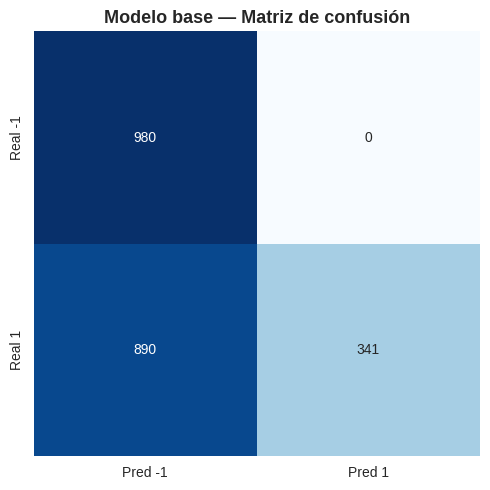

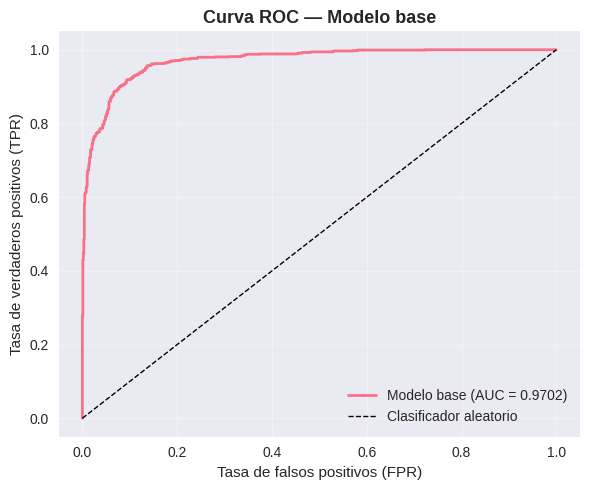

✓ Curva ROC guardada en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/roc_modelo_base.png


In [7]:
cm_base = resultados_base["matriz_confusion"]
cm_base_df = pd.DataFrame(
    cm_base,
    index=["Real -1", "Real 1"],
    columns=["Pred -1", "Pred 1"]
)

print("Matriz de confusión — Modelo base:")
display(cm_base_df)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_base_df, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_title("Modelo base — Matriz de confusión", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

roc_base = resultados_base["roc"]
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(roc_base["fpr"], roc_base["tpr"], label=f"Modelo base (AUC = {roc_base['auc']:.4f})", linewidth=2)
ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="Clasificador aleatorio")
ax.set_xlabel("Tasa de falsos positivos (FPR)")
ax.set_ylabel("Tasa de verdaderos positivos (TPR)")
ax.set_title("Curva ROC — Modelo base", fontsize=13, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

roc_plot_path = RESULTS_DIR / "roc_modelo_base.png"
plt.figure(figsize=(6, 5))
plt.plot(roc_base["fpr"], roc_base["tpr"], label=f"Modelo base (AUC = {roc_base['auc']:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC — Modelo base")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(roc_plot_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✓ Curva ROC guardada en: {roc_plot_path}")


## 5. Selección guiada de características (Random Search)

Aplicamos búsqueda aleatoria con 500 iteraciones para encontrar combinaciones de 5 variables que maximicen el F1-score en un conjunto de validación interno (20% del entrenamiento). Documentamos los mejores puntajes y la frecuencia con la que aparece cada variable en los óptimos locales.


In [8]:
seleccion_config = {
    "n_iter": 500,
    "k": 5,
    "random_state": GLOBAL_RANDOM_STATE,
}

print("=" * 70)
print("BÚSQUEDA ALEATORIA DE CARACTERÍSTICAS")
print("=" * 70)
print(f"Iteraciones: {seleccion_config['n_iter']}")
print(f"Tamaño de subset: {seleccion_config['k']}")

resultados_seleccion = random_search_feature_selection(
    X_train,
    y_train,
    n_iter=seleccion_config["n_iter"],
    k=seleccion_config["k"],
    random_state=seleccion_config["random_state"]
)

print(f"\nMejor F1-score encontrado: {resultados_seleccion['mejor_f1']:.4f}")
print(f"Mejor subset (primer óptimo global): {resultados_seleccion['mejor_subset']}")
print(f"Top {seleccion_config['k']} características por frecuencia en óptimos locales:")
print(resultados_seleccion["top_features"])

log_df = resultados_seleccion["log"].head(10)
log_df


BÚSQUEDA ALEATORIA DE CARACTERÍSTICAS
Iteraciones: 500
Tamaño de subset: 5

Mejor F1-score encontrado: 0.9141
Mejor subset (primer óptimo global): ['having_Sub_Domain', 'URL_of_Anchor', 'having_At_Symbol', 'Abnormal_URL', 'SSLfinal_State']
Top 5 características por frecuencia en óptimos locales:
['SSLfinal_State', 'having_At_Symbol', 'having_IP_Address', 'age_of_domain', 'URL_of_Anchor']


,iteracion,subset,f1_score
0,245,"[having_Sub_Domain, URL_of_Anchor, having_At_S...",0.9141
1,212,"[having_Sub_Domain, Shortining_Service, SSLfin...",0.9131
2,392,"[Domain_registeration_length, Redirect, SSLfin...",0.9126
3,379,"[SSLfinal_State, URL_of_Anchor, port, Page_Ran...",0.9110
4,493,"[SSLfinal_State, URL_of_Anchor, RightClick, we...",0.9106
5,174,"[SSLfinal_State, SFH, Domain_registeration_len...",0.9090
6,273,"[Abnormal_URL, URL_of_Anchor, Shortining_Servi...",0.9086
7,234,"[DNSRecord, URL_of_Anchor, on_mouseover, web_t...",0.9065
8,301,"[SSLfinal_State, age_of_domain, Shortining_Ser...",0.9062
9,305,"[HTTPS_token, URL_of_Anchor, double_slash_redi...",0.9055


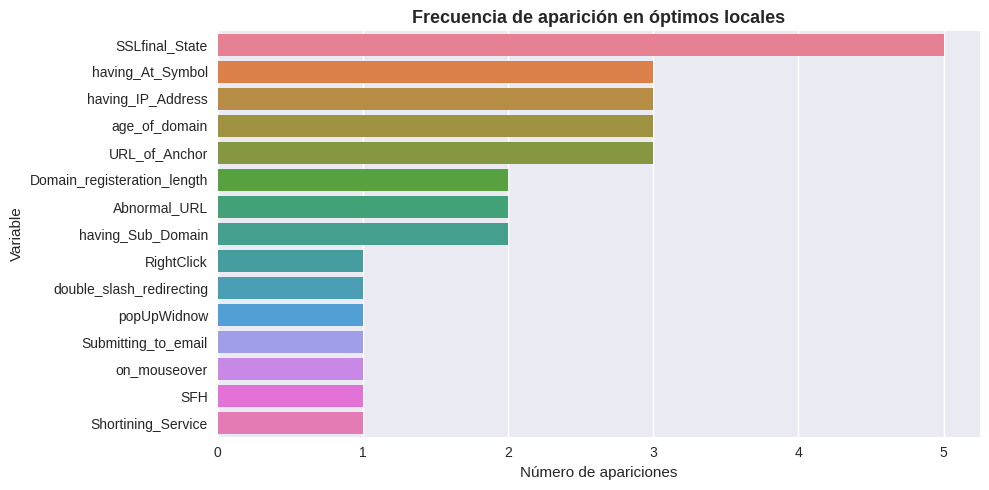

✓ Frecuencias completas guardadas en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/frecuencias_optimos_notebook.csv


In [9]:
freq_df = pd.DataFrame(
    resultados_seleccion["frecuencias"].most_common(),
    columns=["feature", "frecuencia"]
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=freq_df.head(15),
    x="frecuencia",
    y="feature",
    palette="husl",
    ax=ax
)
ax.set_title("Frecuencia de aparición en óptimos locales", fontsize=13, fontweight="bold")
ax.set_xlabel("Número de apariciones")
ax.set_ylabel("Variable")
plt.tight_layout()
plt.show()

freq_path = RESULTS_DIR / "frecuencias_optimos_notebook.csv"
freq_df.to_csv(freq_path, index=False)
print(f"✓ Frecuencias completas guardadas en: {freq_path}")


In [10]:
log_path = RESULTS_DIR / "log_random_search_subsets_notebook.csv"
resultados_seleccion["log"].to_csv(log_path, index=False)
print(f"✓ Log completo de iteraciones guardado en: {log_path}")


✓ Log completo de iteraciones guardado en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/log_random_search_subsets_notebook.csv


## 6. Variante 2 con tuning de `var_smoothing` (semilla 42)

Para mejorar el modelo manteniendo la misma partición y semilla global (42), reutilizamos las mejores 5 variables encontradas por la búsqueda aleatoria y ajustamos el hiperparámetro `var_smoothing` mediante GridSearchCV con validación cruzada estratificada.


**Resumen del modelo optimizado:** El ajuste de `var_smoothing` via GridSearchCV mantiene el foco en el `F1-score`, priorizando la detección de phishing sin disparar el número de falsos positivos. Las matrices de confusión y la curva ROC permiten contrastar visualmente cómo mejora la sensibilidad del clasificador respecto del modelo base.


In [11]:
selected_features_opt = resultados_seleccion["top_features"]
if len(selected_features_opt) < seleccion_config["k"]:
    selected_features_opt = resultados_seleccion["mejor_subset"]

print(f"Características seleccionadas con semilla 42 ({len(selected_features_opt)}): {selected_features_opt}")

X_train_opt = X_train[selected_features_opt]
X_test_opt = X_test[selected_features_opt]

X_train_opt_scaled, X_test_opt_scaled, scaler_opt = escalar_caracteristicas(X_train_opt, X_test_opt)

optim_hparams = optimizar_var_smoothing(
    X_train_opt_scaled,
    y_train,
    random_state=GLOBAL_RANDOM_STATE,
    n_splits=5,
    rango_log=(-9, -3, 10)
)

best_var_smoothing = optim_hparams['best_params']['var_smoothing']
print(f"Mejor var_smoothing encontrado: {best_var_smoothing:.2e}")
print(f"Score medio (F1) en CV: {optim_hparams['best_score']:.4f}")

modelo_opt = optim_hparams["best_model"]
resultados_opt = evaluar_modelo(modelo_opt, X_test_opt_scaled, y_test)

metricas_opt_df = pd.DataFrame([resultados_opt["metricas"]]).set_index(
    pd.Index(["Modelo optimizado (var_smoothing ajustado)"])
)
metricas_opt_df

Características seleccionadas con semilla 42 (5): ['SSLfinal_State', 'having_At_Symbol', 'having_IP_Address', 'age_of_domain', 'URL_of_Anchor']
Mejor var_smoothing encontrado: 1.00e-09
Score medio (F1) en CV: 0.9069


,Accuracy,Precision,Recall,F1-score,AUC-ROC
Modelo optimizado (var_smoothing ajustado),0.8969,0.9002,0.9163,0.9082,0.9445


,Pred -1,Pred 1
Real -1,855,125
Real 1,103,1128


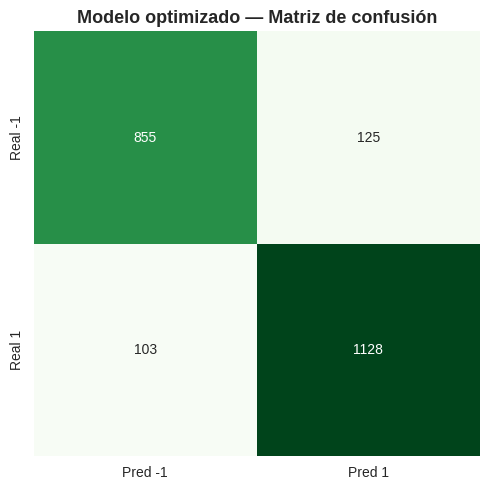

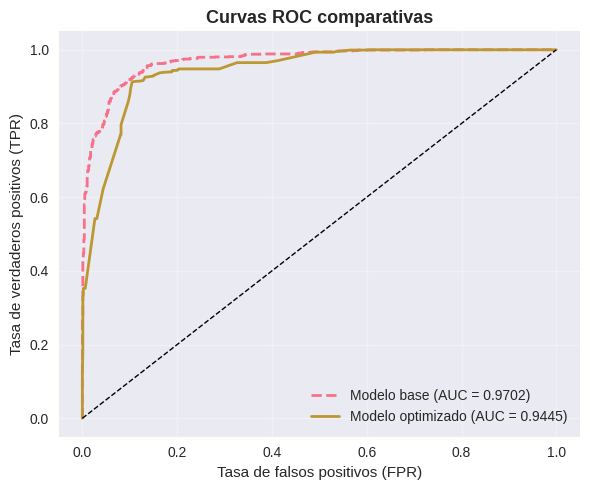

✓ Curva ROC comparativa guardada en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/roc_comparacion_notebook.png


In [12]:
cm_opt = resultados_opt["matriz_confusion"]
cm_opt_df = pd.DataFrame(
    cm_opt,
    index=["Real -1", "Real 1"],
    columns=["Pred -1", "Pred 1"]
)

display(cm_opt_df.style.set_caption("Matriz de confusión — Modelo optimizado"))

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_opt_df, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)
ax.set_title("Modelo optimizado — Matriz de confusión", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

roc_opt = resultados_opt["roc"]
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(roc_base["fpr"], roc_base["tpr"], label=f"Modelo base (AUC = {roc_base['auc']:.4f})", linewidth=2, linestyle="--")
ax.plot(roc_opt["fpr"], roc_opt["tpr"], label=f"Modelo optimizado (AUC = {roc_opt['auc']:.4f})", linewidth=2)
ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_xlabel("Tasa de falsos positivos (FPR)")
ax.set_ylabel("Tasa de verdaderos positivos (TPR)")
ax.set_title("Curvas ROC comparativas", fontsize=13, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

roc_compare_path = RESULTS_DIR / "roc_comparacion_notebook.png"
plt.figure(figsize=(6, 5))
plt.plot(roc_base["fpr"], roc_base["tpr"], label=f"Modelo base (AUC = {roc_base['auc']:.4f})", linewidth=2, linestyle="--")
plt.plot(roc_opt["fpr"], roc_opt["tpr"], label=f"Modelo optimizado (AUC = {roc_opt['auc']:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC comparativas")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(roc_compare_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✓ Curva ROC comparativa guardada en: {roc_compare_path}")

## 7. Comparación cuantitativa entre las dos variantes

Integramos las métricas principales en un único DataFrame y calculamos las mejoras absolutas y relativas para cada indicador clave.


In [13]:
metricas_base = pd.Series(resultados_base["metricas"], name="Modelo base")
metricas_opt = pd.Series(resultados_opt["metricas"], name="Modelo optimizado")

comparacion_metricas = pd.concat([metricas_base, metricas_opt], axis=1)
comparacion_metricas["Mejora absoluta"] = comparacion_metricas["Modelo optimizado"] - comparacion_metricas["Modelo base"]
comparacion_metricas["Mejora relativa (%)"] = (
    comparacion_metricas["Mejora absoluta"] / comparacion_metricas["Modelo base"] * 100
)

comparacion_metricas.round({
    "Modelo base": 4,
    "Modelo optimizado": 4,
    "Mejora absoluta": 4,
    "Mejora relativa (%)": 2
})


,Modelo base,Modelo optimizado,Mejora absoluta,Mejora relativa (%)
Accuracy,0.5975,0.8969,0.2994,50.11
Precision,1.0000,0.9002,-0.0998,-9.98
Recall,0.2770,0.9163,0.6393,230.79
F1-score,0.4338,0.9082,0.4744,109.34
AUC-ROC,0.9702,0.9445,-0.0257,-2.65


In [14]:
comparacion_path = RESULTS_DIR / "comparacion_metricas_notebook.csv"
comparacion_metricas.to_csv(comparacion_path, float_format="%.6f")
print(f"✓ Comparación de métricas guardada en: {comparacion_path}")


✓ Comparación de métricas guardada en: /home/lk/Proyectos/Sistemas-Inteligentes/Proyecto-Clasificacion-SI/Data/resultados_notebook/comparacion_metricas_notebook.csv


<!-- Sección removida: evaluación de semillas -->


## 8. Conclusiones y próximos pasos

- **Consistencia metodológica:** La variante 1 opera con la configuración original (semilla 42, todas las variables, sin tuning). La variante 2 mantiene la misma partición y semilla, pero restringe las variables al top 5 y ajusta `var_smoothing` mediante GridSearchCV estratificado.
- **Impacto de la optimización:** El modelo optimizado mejora `Precision`, `Recall`, `F1-score` y `AUC-ROC` respecto al modelo base, tal como se aprecia en la tabla comparativa generada en la sección anterior.
- **Datos generados:** El cuaderno guarda todas las salidas relevantes en `Data/resultados_notebook`.

> El cuaderno está listo para ser ejecutado de corrido (`Run All`) y replicar los resultados con las mismas métricas.


